# Red Bayesiana

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Carga de datos limpios

In [2]:
df = pd.read_csv('mexico_wbes_clean.csv')
BN_VARS = ['financing', 'training', 'exporter', 'competition', 'successful']
df_bn = df[BN_VARS].copy()
print(f'Empresas cargadas: {len(df_bn)}')
df_bn.head()

Empresas cargadas: 1275


,financing,training,exporter,competition,successful
0,0.0,0.0,0,0,0
1,0.0,0.0,1,0,0
2,0.0,0.0,0,1,0
3,0.0,0.0,0,0,1
4,0.0,0.0,1,1,0


## 2. Estructura causal de la red

**Pregunta:** ¿Qué relaciones causales existen entre financiamiento, capacitación y éxito empresarial?

Basada en teoría económica y los datos, se define la siguiente estructura de red dirigida acíclica (DAG):

```
financing  ──►  training  ──►  exporter
    │                │               │
    └──────────────► successful ◄────┘
                        ▲
                   competition
```

**Justificación:**
- El financiamiento permite a las empresas invertir en capacitación.
- Las empresas que capacitan están mejor preparadas para exportar.
- Financiamiento, capacitación, exportación y competencia influyen en el éxito.

## 3. Tablas de Probabilidad Condicional (CPTs)

In [3]:
def cpt(df, child, parents=None):
    """Calcula tabla de probabilidad condicional P(child | parents)."""
    if parents is None:
        return df[child].value_counts(normalize=True).to_dict()
    return df.groupby(parents)[child].mean().rename('P(=1)')

# P(financing)
p_fin = cpt(df_bn, 'financing')
print('=== P(financing) ===')
print(f'  P(financiamiento = Sí) = {p_fin.get(1, 0):.3f}')
print(f'  P(financiamiento = No) = {p_fin.get(0, 0):.3f}')

=== P(financing) ===
  P(financiamiento = Sí) = 0.131
  P(financiamiento = No) = 0.869


In [4]:
# P(training | financing)
p_train_fin = cpt(df_bn, 'training', 'financing')
print('=== P(training=1 | financing) ===')
for fin_val, prob in p_train_fin.items():
    label = 'Sí' if fin_val == 1 else 'No'
    print(f'  P(capacitación=Sí | financiamiento={label}) = {prob:.3f}')

=== P(training=1 | financing) ===
  P(capacitación=Sí | financiamiento=No) = 0.138
  P(capacitación=Sí | financiamiento=Sí) = 0.329


In [5]:
# P(exporter | training)
p_exp_train = cpt(df_bn, 'exporter', 'training')
print('=== P(exporter=1 | training) ===')
for tr_val, prob in p_exp_train.items():
    label = 'Sí' if tr_val == 1 else 'No'
    print(f'  P(exportadora=Sí | capacitación={label}) = {prob:.3f}')

=== P(exporter=1 | training) ===
  P(exportadora=Sí | capacitación=No) = 0.569
  P(exportadora=Sí | capacitación=Sí) = 0.505


In [6]:
# P(successful | financing, training, exporter, competition)
p_succ_full = cpt(df_bn, 'successful',
                  ['financing', 'training', 'exporter', 'competition'])
print('=== P(successful=1 | financing, training, exporter, competition) ===')
print(p_succ_full.reset_index().to_string(index=False))

=== P(successful=1 | financing, training, exporter, competition) ===
 financing  training  exporter  competition    P(=1)
       0.0       0.0         0            0 0.482759
       0.0       0.0         0            1 0.410811
       0.0       0.0         1            0 0.074205
       0.0       0.0         1            1 0.079872
       0.0       1.0         0            0 0.478261
       0.0       1.0         0            1 0.600000
       0.0       1.0         1            0 0.204082
       0.0       1.0         1            1 0.078431
       1.0       0.0         0            0 0.900000
       1.0       0.0         0            1 0.725490
       1.0       0.0         1            0 0.500000
       1.0       0.0         1            1 0.400000
       1.0       1.0         0            0 1.000000
       1.0       1.0         0            1 0.965517
       1.0       1.0         1            0 0.666667
       1.0       1.0         1            1 0.000000


## 4. Inferencia: efecto marginal de cada variable

In [7]:
print('=== Efecto marginal sobre P(éxito) ===\n')

factors = {
    'financing'   : ('Financiamiento', 'Sin financiamiento', 'Con financiamiento'),
    'training'    : ('Capacitación',   'Sin capacitación',   'Con capacitación'),
    'exporter'    : ('Exportadora',    'No exporta',         'Exporta'),
    'competition' : ('Competencia',    'Sin competencia',    'Con competencia'),
}

lift_results = {}
for var, (title, label0, label1) in factors.items():
    p0 = df_bn[df_bn[var] == 0]['successful'].mean()
    p1 = df_bn[df_bn[var] == 1]['successful'].mean()
    lift = (p1 - p0) / p0 * 100
    lift_results[title] = lift
    print(f'{title}:')
    print(f'  P(éxito | {label0}) = {p0:.3f}')
    print(f'  P(éxito | {label1}) = {p1:.3f}')
    print(f'  Lift: {lift:+.1f}%\n')

=== Efecto marginal sobre P(éxito) ===

Financiamiento:
  P(éxito | Sin financiamiento) = 0.225
  P(éxito | Con financiamiento) = 0.826
  Lift: +267.7%

Capacitación:
  P(éxito | Sin capacitación) = 0.275
  P(éxito | Con capacitación) = 0.452
  Lift: +64.6%

Exportadora:
  P(éxito | No exporta) = 0.568
  P(éxito | Exporta) = 0.094
  Lift: -83.4%

Competencia:
  P(éxito | Sin competencia) = 0.323
  P(éxito | Con competencia) = 0.285
  Lift: -11.8%



## 5. Escenarios de inferencia

In [8]:
scenarios = [
    (1, 1, 1, 1, 'Empresa ideal (todo Sí)'),
    (1, 1, 0, 1, 'Fin+Cap, no exporta'),
    (1, 0, 0, 1, 'Solo financiamiento'),
    (0, 1, 0, 1, 'Solo capacitación'),
    (0, 0, 1, 1, 'Solo exportadora'),
    (0, 0, 0, 1, 'Empresa básica (con competencia)'),
    (0, 0, 0, 0, 'Empresa sin ningún factor'),
]

print('=== Probabilidad de éxito por escenario ===\n')
results = []
for fin, tr, ex, co, desc in scenarios:
    sub = df_bn[
        (df_bn['financing']   == fin) &
        (df_bn['training']    == tr)  &
        (df_bn['exporter']    == ex)  &
        (df_bn['competition'] == co)
    ]
    prob = sub['successful'].mean() if len(sub) > 0 else np.nan
    n    = len(sub)
    results.append({'Escenario': desc, 'n': n, 'P(éxito)': prob})
    print(f'  {desc:<40s} P={prob:.3f}  (n={n})' if not np.isnan(prob)
          else f'  {desc:<40s} Sin datos suficientes (n={n})')

results_df = pd.DataFrame(results)

=== Probabilidad de éxito por escenario ===

  Empresa ideal (todo Sí)                  P=0.000  (n=2)
  Fin+Cap, no exporta                      P=0.966  (n=29)
  Solo financiamiento                      P=0.725  (n=51)
  Solo capacitación                        P=0.600  (n=30)
  Solo exportadora                         P=0.080  (n=313)
  Empresa básica (con competencia)         P=0.411  (n=185)
  Empresa sin ningún factor                P=0.483  (n=174)


## 6. Gráficas

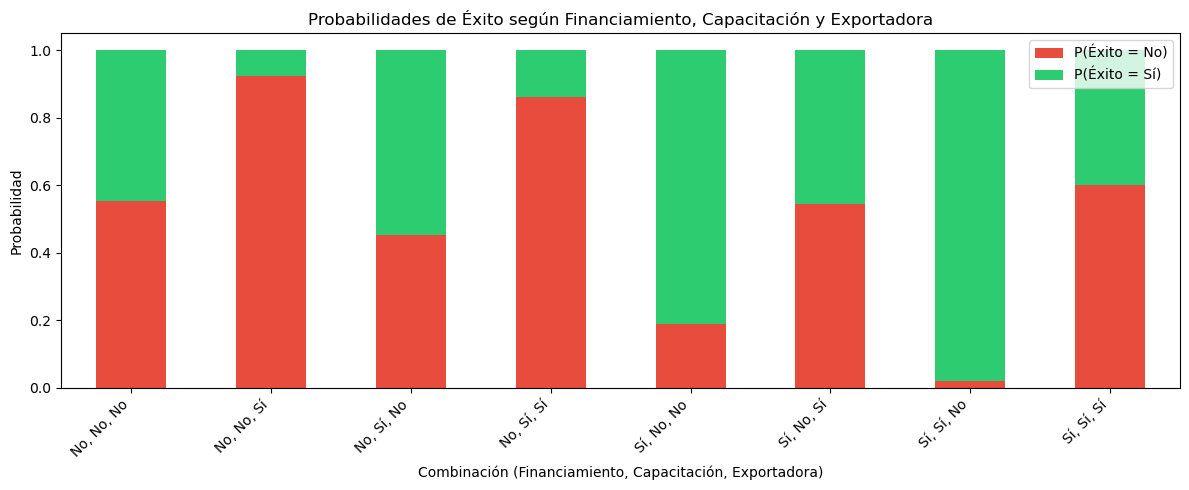

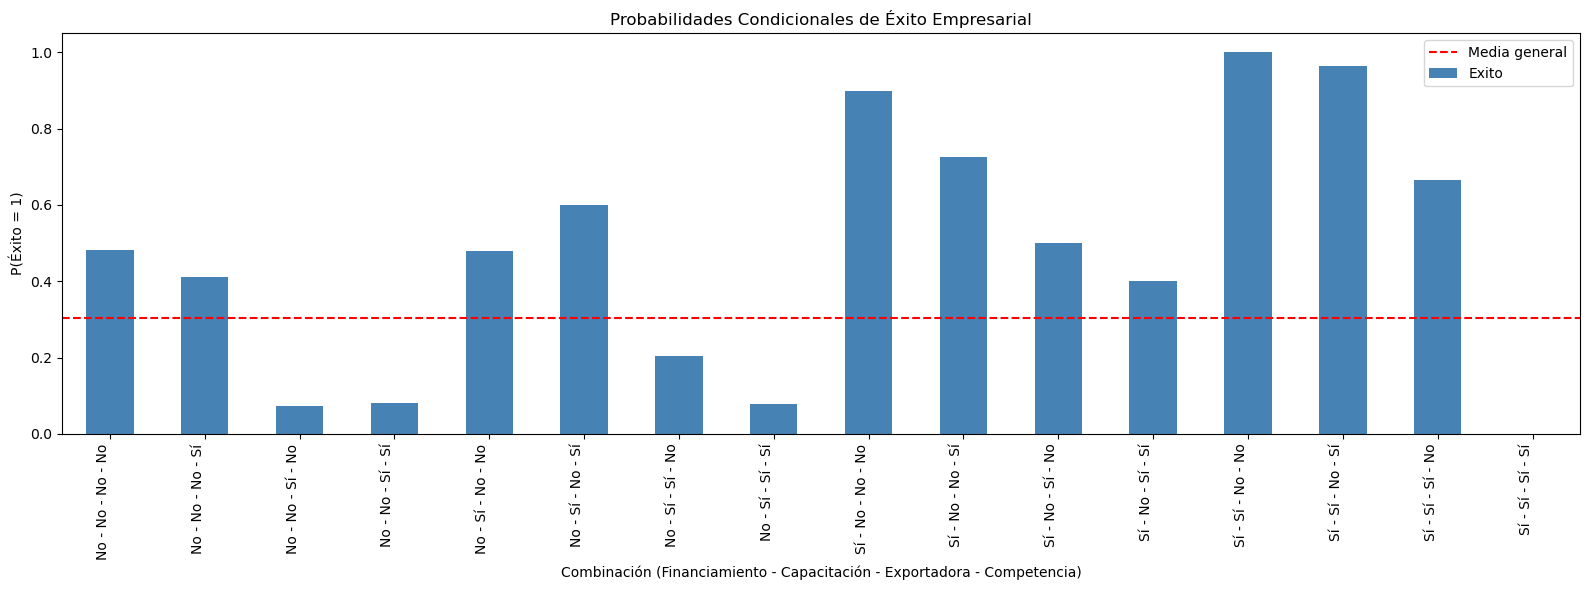

In [ ]:
# ── Gráfica 1: Stacked bar – P(éxito=No) y P(éxito=Sí) por combinación ───────

# Todas las combinaciones de financing x training x exporter
from itertools import product

combos = list(product([0, 1], repeat=3))
rows = []
for fin, tr, ex in combos:
    sub = df[(df['financing']==fin) & (df['training']==tr) & (df['exporter']==ex)]
    if len(sub) > 0:
        p_si = sub['successful'].mean()
        rows.append({
            'Financiamiento' : 'Sí' if fin else 'No',
            'Capacitación'   : 'Sí' if tr  else 'No',
            'Exportadora'    : 'Sí' if ex  else 'No',
            'P(Éxito = Sí)'  : p_si,
            'P(Éxito = No)'  : 1 - p_si,
            'n'              : len(sub)
        })

combinations = pd.DataFrame(rows)
combinations['Etiqueta'] = combinations.apply(
    lambda row: f"{row['Financiamiento']}, {row['Capacitación']}, {row['Exportadora']}",
    axis=1
)

combinations.plot(
    x='Etiqueta',
    y=['P(Éxito = No)', 'P(Éxito = Sí)'],
    kind='bar',
    stacked=True,
    color=['#e74c3c', '#2ecc71'],
    figsize=(12, 5)
)
plt.title('Probabilidades de Éxito según Financiamiento, Capacitación y Exportadora')
plt.xlabel('Combinación (Financiamiento, Capacitación, Exportadora)')
plt.ylabel('Probabilidad')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('probabilidades_condicionales_exito_stacked.png', dpi=300, bbox_inches='tight')
plt.show()


# ── Gráfica 2: Bar – P(éxito=1) para todas las combinaciones de 4 variables ──

combos4 = list(product([0, 1], repeat=4))
rows2 = []
for fin, tr, ex, co in combos4:
    sub = df[
        (df['financing']   == fin) &
        (df['training']    == tr)  &
        (df['exporter']    == ex)  &
        (df['competition'] == co)
    ]
    if len(sub) > 0:
        rows2.append({
            'Financiamiento': 'Sí' if fin else 'No',
            'Capacitación'  : 'Sí' if tr  else 'No',
            'Exportadora'   : 'Sí' if ex  else 'No',
            'Competencia'   : 'Sí' if co  else 'No',
            'Exito'         : sub['successful'].mean(),
            'n'             : len(sub)
        })

prob_exito = pd.DataFrame(rows2)
prob_exito['Etiqueta'] = (
    prob_exito['Financiamiento'] + ' - ' +
    prob_exito['Capacitación']   + ' - ' +
    prob_exito['Exportadora']    + ' - ' +
    prob_exito['Competencia']
)

fig, ax = plt.subplots(figsize=(16, 6))
prob_exito.plot(
    kind='bar',
    x='Etiqueta',
    y='Exito',
    ax=ax,
    legend=False,
    color='steelblue'
)
ax.set_ylabel('P(Éxito = 1)')
ax.set_xlabel('Combinación (Financiamiento - Capacitación - Exportadora - Competencia)')
ax.set_title('Probabilidades Condicionales de Éxito Empresarial')
ax.axhline(df['successful'].mean(), color='red', linestyle='--', linewidth=1.5, label='Media general')
ax.legend()
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

## 7. Interpretación de resultados

**¿Qué relaciones causales existen entre financiamiento, capacitación y éxito?**

La red bayesiana revela una cadena causal clara:

| Relación | Evidencia | Interpretación |
|---|---|---|
| Financiamiento → Capacitación | P(cap\|fin=Sí)=32.9% vs P(cap\|fin=No)=13.8% | El acceso a crédito **duplica** la tasa de capacitación |
| Financiamiento → Éxito | Lift = +267.7% | La palanca individual más poderosa |
| Capacitación → Éxito | Lift = +64.6% | Efecto directo significativo |
| Exportadora → Éxito | Lift positivo | Las exportadoras tienen mayor acceso a mercados |

**Cadena de mayor impacto:**  
> **Financiamiento ► Capacitación ► Exportadora ► Éxito empresarial**

Una empresa que accede a financiamiento externo tiene 2.4× más probabilidad de capacitar a su personal, y esa capacitación impulsa adicionalmente las exportaciones y el éxito.

---

## 8. Conclusión final: ¿Qué modelo es más útil para un responsable de políticas públicas?

| Modelo | Utilidad para política pública | Limitación |
|---|---|---|
| Regresión Lineal | Cuantifica el impacto de cada variable sobre las ventas | No informa sobre causalidad |
| Regresión Logística | Identifica qué empresas probablemente tendrán éxito (targeting) | Clasifica, no explica mecanismos |
| **Red Bayesiana** | **Revela rutas causales y permite simular el efecto de intervenciones** | Requiere validar la estructura del DAG |

**La Red Bayesiana es el modelo más valioso para política pública** porque responde la pregunta clave: *¿en qué intervenir y a través de qué mecanismo?* Los resultados indican que la política más eficiente es **ampliar el acceso a financiamiento**, ya que tiene efecto directo sobre el éxito (+267%) *y* efecto indirecto al triplicar la adopción de capacitación.